# Install Libraries

In [15]:
# !pip install clearml
# !pip install xgboost
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install torch
# !pip install tensorboard
# !pip install optuna

# Imports

In [3]:
import clearml
from clearml.automation import UniformParameterRange, UniformIntegerParameterRange
from clearml.automation import HyperParameterOptimizer
from clearml.automation import GridSearch
from clearml.automation.optuna import OptimizerOptuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import psutil
d = psutil.disk_usage('/')
print(f"total: {d.total} bytes")
print(f"used: {d.used} bytes")
print(f"free: {d.free} bytes")

total: 52741595136 bytes
used: 19051315200 bytes
free: 31472713728 bytes


# Connect to Browser

In [5]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=CEXP8BVY587LDKN4L2N6
%env CLEARML_API_SECRET_KEY=QzzgTEb2qDtZTg8JwPPXVSe4lMiMQiGJjFTwanDuIqimPJjwhR

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=CEXP8BVY587LDKN4L2N6
env: CLEARML_API_SECRET_KEY=QzzgTEb2qDtZTg8JwPPXVSe4lMiMQiGJjFTwanDuIqimPJjwhR


In [6]:
clearml.browser_login()

In [7]:
from clearml import Task

In [40]:
# Task.get_task('c1632b22d36a4754bbadc094942fb5a2').delete()

# Machine Learning

## Create ClearML Task and Data

In [ ]:
task_xgb = Task.init(project_name="lab_03_devops", 
                 task_name="xgb_cricket_prediction", 
                 output_uri=True)
all_projects = Task.get_projects()
lab_03_devops_project = all_projects[-1]
print(lab_03_devops_project)

In [ ]:
ipl_df = pd.read_csv('data/ipl_data.csv', low_memory=True)
ipl_df.drop(['id'], axis=1, inplace=True)
print(ipl_df.shape, ipl_df.columns)

In [ ]:
ipl_df.head(5)

In [ ]:
ipl_df.dtypes

In [ ]:
cols_to_convert_to_category = ipl_df.columns[:-1]
ipl_df[cols_to_convert_to_category] = ipl_df[cols_to_convert_to_category].astype('category')

In [ ]:
ipl_df.dtypes

## Model Train, Test and Basic Logging

In [ ]:
X = ipl_df.drop(['outcome'], axis=1)
y = ipl_df['outcome']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
data_train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
data_val_matrix = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
data_test_matrix = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [ ]:
params = {
    'max_depth': 2,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'colsample_bytree': 0.5,
    'eval_metric': 'logloss',
    'subsample': 0.5,
    'gamma':0.1
}
task_xgb.connect(params)

In [ ]:
xgb_model = xgb.train(
        params,
        data_train_matrix,
        num_boost_round=150,
        evals=[(data_train_matrix, "train"), (data_val_matrix, "eval")],
        verbose_eval=0,
)
xgb_model.save_model("best_model")

In [ ]:
y_pred_probas = xgb_model.predict(data_test_matrix)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_probas]
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy = {round(accuracy, 3)}")
cm = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix")
ConfusionMatrixDisplay(cm).plot(ax=plt.gca())

In [ ]:
task_xgb.close()

# HPO for ML

## Do HPO Search for XGB

In [ ]:
xgb_task_to_optimize = '0e79f82d492b4019a0230d95f40f2cbc'

xgb_optimizer = HyperParameterOptimizer(
    base_task_id=xgb_task_to_optimize,
    hyper_parameters=[
        UniformIntegerParameterRange('General/max_depth', min_value=3, max_value=7, step_size=2),
        UniformParameterRange('General/learning_rate', min_value=0.001, max_value=0.1, step_size=50),
        UniformParameterRange('General/colsample_bytree', min_value=0.5, max_value=1, step_size=0.1),
        UniformParameterRange('General/subsample', min_value=0.5, max_value=1, step_size=0.1),
        UniformParameterRange('General/gamma', min_value=0.1, max_value=0.3, step_size=0.1),
    ],
    # setting the objective metric we want to maximize/minimize
    objective_metric_title='train',
    objective_metric_series='logloss',
    objective_metric_sign='min',  # maximize or minimize the objective metric

    # setting optimizer - clearml supports GridSearch, RandomSearch, OptimizerBOHB and OptimizerOptuna
    optimizer_class=GridSearch,
    
    # Configuring optimization parameters
    # execution_queue='xgb_GridCV_queue',  # queue to schedule the experiments for execution
    max_number_of_concurrent_tasks=7,  # number of concurrent experiments
    optimization_time_limit=20.,  # set the time limit for the optimization process
    compute_time_limit=60,  # set the compute time limit (sum of execution time on all machines)
    total_max_jobs=20,  # set the maximum number of experiments for the optimization.  # Converted to total number of iteration for OptimizerBOHB
    # min_iteration_per_job=15000,  # minimum number of iterations per experiment, till early stopping
    # max_iteration_per_job=150000,  # maximum number of iterations per experiment
)

xgb_optimizer.set_report_period(0.1)  # setting the time gap between two consecutive reports
xgb_optimizer.start()  
xgb_optimizer.wait()  # wait until process is done
xgb_optimizer.stop()

## Print Results of HPO for XGB

In [43]:
take_items = lambda d, n: [print(f"{k}: {d[k]}") for k in list(d.keys())[:n]]
k = 3
top_exp = xgb_optimizer.get_top_experiments(top_k=k)
print('Top {} experiments are:'.format(k))
for n, t in enumerate(top_exp, 1):
    print("------------------------------------------------")
    print(f"Rank = {n}: task_id = {t.id}")
    print("------------------------------------------------")
    take_items(t.get_parameters(), len(t.get_parameters()))

Progress report #191 completed, sleeping for 0.25 minutes
Top 3 experiments are:
------------------------------------------------
Rank = 1: task_id = 0f1678866a784817b876ea00cf4fcea4
------------------------------------------------
General/max_depth: 3
General/learning_rate: 0.1
General/objective: binary:logistic
General/nthread: 4
General/colsample_bytree: 0.5
General/eval_metric: logloss
General/subsample: 0.5
General/gamma: 0.3
------------------------------------------------
Rank = 2: task_id = 3a05e67814524574b6179a6747407a74
------------------------------------------------
General/max_depth: 3
General/learning_rate: 0.1
General/objective: binary:logistic
General/nthread: 4
General/colsample_bytree: 0.5
General/eval_metric: logloss
General/subsample: 0.6
General/gamma: 0.3
------------------------------------------------
Rank = 3: task_id = 1643f8bec9604a549dc3bec2d6d0fd63
------------------------------------------------
General/max_depth: 3
General/learning_rate: 0.1
General/obje

# Deep Learning with Tensorboard and Pytorch

## Create ML Task and Data

In [8]:
task_nn = Task.init(project_name="lab_03_devops", 
                 task_name="TB_cricket_prediction", 
                 output_uri=True)
all_projects = Task.get_projects()
lab_03_devops_project = all_projects[-1]
print(lab_03_devops_project)
writer_nn = SummaryWriter()

ClearML Task: created new task id=738858ebf22f457ebb27a1d40c0e9b2f
2023-05-25 09:16:23,419 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ed74f016950a48ea96a7b667648d4a7c/experiments/738858ebf22f457ebb27a1d40c0e9b2f/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
<projects.Project: {
    "id": "ed74f016950a48ea96a7b667648d4a7c",
    "name": "lab_03_devops",
    "basename": "lab_03_devops",
    "description": "# Cricket_Match_Outcome_Predictioon\n## Steps",
    "user": "99c0427d647d48d9a72ce56bb0e511b5",
    "company": "c4a3a246af4a4e28ba4683ae2352b187",
    "created": "2023-05-24 15:20:47.122000+00:00",
    "tags": [],
    "system_tags": [],
    "last_update": "2023-05-25 09:16:22.049000+00:00"
}>
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


## Model Train, Test and TensorBoard Logging

In [10]:
# Define the custom dataset class
class IPLDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)
    
# Get data in desired format and split
ipl_df = pd.read_csv('data/ipl_data.csv', low_memory=True)
ipl_df.drop(['id'], axis=1, inplace=True)
X, y = ipl_df.iloc[:, :-1], ipl_df.iloc[:, -1]
X = pd.get_dummies(X)
X, y = X.to_numpy(), y.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Instantiate the datasets and dataloaders
train_dataset = IPLDataset(X_train, y_train)
val_dataset = IPLDataset(X_val, y_val)
test_dataset = IPLDataset(X_test, y_test)

In [11]:
params = {
        'input_size': X.shape[1],
        'hidden_size': X.shape[1] // 2,
        'learning_rate': 0.001,
        'batch_size': 32,
        'num_epochs':50,
        'dropout_p':0.5,
}

task_nn.connect(params)

# Hyperparameters
input_size = params.get('input_size')
hidden_size = params.get('hidden_size')
learning_rate = params.get('learning_rate')
batch_size = params.get('batch_size')
num_epochs = params.get('num_epochs')
dropout_p = params.get('dropout_p')

In [12]:
# Define the neural network architecture
class IPL_match_outcome_BNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p):
        super(IPL_match_outcome_BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 8)
        self.fc4 = nn.Linear(hidden_size // 8, 1)
        self.dropout = nn.Dropout(dropout_p)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

In [13]:
# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Model
model = IPL_match_outcome_BNN(input_size, hidden_size, dropout_p)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

IPL_match_outcome_BNN(
  (fc1): Linear(in_features=1077, out_features=538, bias=True)
  (fc2): Linear(in_features=538, out_features=269, bias=True)
  (fc3): Linear(in_features=269, out_features=67, bias=True)
  (fc4): Linear(in_features=67, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


In [14]:
# Train
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert predictions and labels to integers for accuracy calculation
        train_predictions = outputs.round().squeeze().detach().cpu().numpy()
        train_labels = labels.detach().cpu().numpy()
        train_correct += (train_predictions == train_labels).sum()
        train_total += len(train_labels)
    
    writer_nn.add_scalar('Train-Epoch-loss', train_loss, epoch * len(train_dataloader) + i)
    # Compute the training accuracy
    train_accuracy = train_correct / train_total

    # Perform validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for inputs, labels in val_dataloader:
        val_outputs = model(inputs)
        val_loss += criterion(val_outputs.squeeze(), labels).item()

        # Convert predictions and labels to integers for accuracy calculation
        val_predictions = val_outputs.round().squeeze().detach().cpu().numpy()
        val_labels = labels.detach().cpu().numpy()
        val_correct += (val_predictions == val_labels).sum()
        val_total += len(val_labels)

    # Compute the validation accuracy
    val_accuracy = val_correct / val_total
    if epoch % 12 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {train_loss:.4f}, \
        Train Accuracy: {train_accuracy:.4f}, \
        Validation Loss: {val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/50],         Train Loss: 15.3040,         Train Accuracy: 0.4804,         Validation Loss: 4.1527,         Validation Accuracy: 0.5052
Epoch [13/50],         Train Loss: 0.0111,         Train Accuracy: 1.0000,         Validation Loss: 3.7331,         Validation Accuracy: 0.8125
Epoch [25/50],         Train Loss: 0.0016,         Train Accuracy: 1.0000,         Validation Loss: 4.3413,         Validation Accuracy: 0.7917
Epoch [37/50],         Train Loss: 0.0013,         Train Accuracy: 1.0000,         Validation Loss: 5.5273,         Validation Accuracy: 0.7812
Epoch [49/50],         Train Loss: 0.0012,         Train Accuracy: 1.0000,         Validation Loss: 6.2095,         Validation Accuracy: 0.7812


Test Accuracy: 0.8442


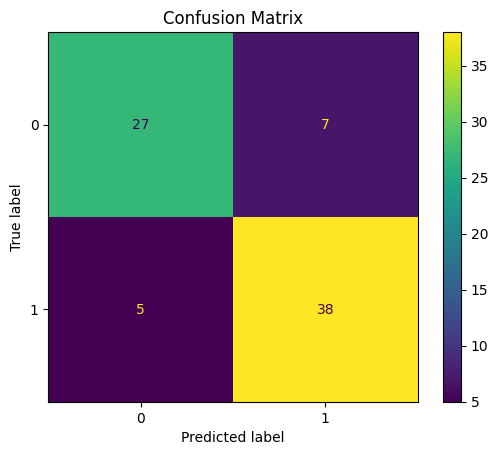

In [18]:
model.eval()
test_predictions = []
test_labels = []
for inputs, labels in test_dataloader:
    outputs = model(inputs)
    predictions = outputs.round().squeeze().detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    test_predictions.extend(predictions)
    test_labels.extend(labels)

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_accuracy = (test_predictions == test_labels).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")
cm = confusion_matrix(test_labels, test_predictions)
plt.title("Confusion Matrix")
ConfusionMatrixDisplay(cm).plot(ax=plt.gca())

In [19]:
writer_nn.close()
task_nn.close()

# HPO for DL

## Do HPO Search for Custom NN

In [ ]:
nn_task_to_optimize = '738858ebf22f457ebb27a1d40c0e9b2f'

nn_optimizer = HyperParameterOptimizer(
    base_task_id=nn_task_to_optimize,
    hyper_parameters=[        
        UniformParameterRange('General/learning_rate', min_value=0.001, max_value=0.1, step_size=48),
        UniformIntegerParameterRange('General/batch_size', min_value=32, max_value=128, step_size=32),
        UniformIntegerParameterRange('General/num_epochs', min_value=30, max_value=75, step_size=15),
        UniformParameterRange('General/dropout_p', min_value=0.4, max_value=0.7, step_size=0.1),
    ],
    # setting the objective metric we want to maximize/minimize
    objective_metric_title='Train-Epoch-loss',
    objective_metric_series='Train-Epoch-loss',
    objective_metric_sign='min',  # maximize or minimize the objective metric

    # setting optimizer - clearml supports GridSearch, RandomSearch, OptimizerBOHB and OptimizerOptuna
    optimizer_class=GridSearch,
    
    # Configuring optimization parameters
    # execution_queue='xgb_GridCV_queue',  # queue to schedule the experiments for execution
    max_number_of_concurrent_tasks=7,  # number of concurrent experiments
    optimization_time_limit=20.,  # set the time limit for the optimization process
    compute_time_limit=60,  # set the compute time limit (sum of execution time on all machines)
    total_max_jobs=20,  # set the maximum number of experiments for the optimization.  # Converted to total number of iteration for OptimizerBOHB
    # min_iteration_per_job=15000,  # minimum number of iterations per experiment, till early stopping
    # max_iteration_per_job=150000,  # maximum number of iterations per experiment
)

nn_optimizer.set_report_period(0.1)  # setting the time gap between two consecutive reports
nn_optimizer.start()  
nn_optimizer.wait()  # wait until process is done
nn_optimizer.stop()

## Print Results of HPO for NN

In [ ]:
take_items = lambda d, n: [print(f"{k}: {d[k]}") for k in list(d.keys())[:n]]
k = 3
top_exp = xgb_optimizer.get_top_experiments(top_k=k)
print('Top {} experiments are:'.format(k))
for n, t in enumerate(top_exp, 1):
    print("------------------------------------------------")
    print(f"Rank = {n}: task_id = {t.id}")
    print("------------------------------------------------")
    take_items(t.get_parameters(), len(t.get_parameters()))